In [0]:
url = 'https://raw.githubusercontent.com/Deepok101/MAIS202_FINAL/master/Combined_News_DJIA.csv'
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv(url)
y = data.Label

In [0]:
#Initial Attempt cleaning my data
#Not used
import re


def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [0]:
#Splitting the data
data = pd.read_csv(url)
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [0]:
#Seperate the text by word
#Second attempt cleaning the data
#Used
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:20]))
    
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:20]))

In [0]:
#Tokenize/Vectorize the data into a vector of size 30,000
from sklearn.feature_extraction.text import CountVectorizer
basicvectorizer = CountVectorizer(max_features=30000, token_pattern=r'\b[^\d\W]+\b', stop_words='english')
basictrain = basicvectorizer.fit_transform(trainheadlines)

basictest = basicvectorizer.transform(testheadlines)

vectorizer = CountVectorizer(max_features=9000, stop_words='english')
X_train = vectorizer.fit_transform(trainheadlines)
X_test = vectorizer.transform(testheadlines)

In [0]:
#Logistics Regression
from sklearn.linear_model import LogisticRegression

logisticsModel = LogisticRegression()
logisticsModel = logisticsModel.fit(basictrain, train["Label"])
#Predicting with Logstics Regression
y_predtest_logist = logisticsModel.predict(basictest)
y_predtrain_logist = logisticsModel.predict(basictrain)
pd.crosstab(test["Label"], y_predtest_logist, rownames=["Actual"], colnames=["Predicted"])
accuracy_score(test["Label"], y_predtest_logist)
print("Logistics Train Regression Accuracy: {0}".format(accuracy_score(train["Label"], y_predtrain_logist)))
print("Logistics Test Regression Accuracy: {0}".format(accuracy_score(test["Label"], y_predtest_logist)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.46825396825396826


In [0]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(basictrain.toarray(), train.Label).predict(basictest.toarray())
y_pred_train1 = gnb.predict(basictrain.toarray())

#Predicting with Naives Bayes
pd.crosstab(test["Label"], y_pred, rownames=["Actual"], colnames=["Predicted"])
accuracy_score(test["Label"], y_pred)
print("Gaussian NB Testing Accuracy {0}".format(accuracy_score(test["Label"], y_pred)))
print("Gaussian NB Training Accuracy {0}".format(accuracy_score(train["Label"], y_pred_train1)))


Gaussian NB Testing Accuracy 0.5211640211640212
Gaussian NB Training Accuracy 1.0


In [0]:
#Random forest classifier
#I had a hard time optimizing this model because it was taking too much time
#The optimal result mentionned in deliverable 2 was from 10 attempts of fine-tuning.
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier()
randomForest.fit(basictrain.toarray(), train['Label'])
y_pred_train_rf = randomForest.predict(basictrain.toarray())
y_pred_test_rf = randomForest.predict(basictest.toarray())

print("Random Forest Training Accuracy {0}".format(accuracy_score(train["Label"], y_pred_train_rf)))
print("Random Forest Testing Accuracy {0}".format(accuracy_score(test["Label"], y_pred_test_rf)))


KeyboardInterrupt: ignored

In [0]:
#First test with the Sequential Model
#Did not write about this in Deliverable 2 because of my current limited knowledge of deep learning
#Will continue in the next stage
from keras.models import Sequential
from keras import layers

input_dim = basictrain.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(1000, input_shape=(10000,), activation='relu'))
model.add(layers.Dense(1000, input_shape=(1000,), activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              10001000  
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 11,003,001
Trainable params: 11,003,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(basictrain, train.Label,
                    epochs=50,
                    verbose=False,
                    validation_data=(basictest, test.Label),
                    batch_size=10)
loss, accuracy = model.evaluate(basictrain, train.Label, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(basictest, test.Label, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [0]:
#Attempt using the LSTM model
#Will implement in the later stage of the project.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 10000, return_sequences = True, input_shape= (basictrain.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(basictrain, train.Label, epochs = 100, batch_size = 32)

Using TensorFlow backend.


## Optimizing three preliminary models

In [0]:
#Optimizing the vocabulary count for vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

feature_size = [5000, 10000, 15000, 20000, 25000, 30000]
testing_score_log = []
training_score_log = []

testing_score_nb = []
training_score_nb = []
print("Fine tuning with the vocabulary size.")
for i in feature_size:
               
  basicvectorizer = CountVectorizer(max_features=i, token_pattern=r'\b[^\d\W]+\b', stop_words='english')
  basictrain = basicvectorizer.fit_transform(trainheadlines)
  basictest = basicvectorizer.transform(testheadlines)

  #Logistics Regression

  logisticsModel = LogisticRegression()
  logisticsModel = logisticsModel.fit(basictrain, train["Label"])
  y_predtest_logist = logisticsModel.predict(basictest)
  y_predtrain_logist = logisticsModel.predict(basictrain)

  #Naive Bayes
  gnb = GaussianNB()
  y_pred = gnb.fit(basictrain.toarray(), train.Label).predict(basictest.toarray())
  y_pred_train1 = gnb.predict(basictrain.toarray())
  print("Vocabulary Size: {0}".format(i))
  print("Logistics Train Regression Accuracy: {0}".format(accuracy_score(train["Label"], y_predtrain_logist)))
  print("Logistics Test Regression Accuracy: {0}".format(accuracy_score(test["Label"], y_predtest_logist)))
  
  print("Naive Bayes Train Regression Accuracy: {0}".format(accuracy_score(train["Label"], y_pred_train1)))
  print("Naive Bayes Test Regression Accuracy: {0}".format(accuracy_score(test["Label"], y_pred)))
  

  testing_score_log.append(accuracy_score(test["Label"], y_predtest_logist))
  training_score_log.append(accuracy_score(train["Label"], y_predtrain_logist))
  
  testing_score_nb.append(accuracy_score(test['Label'], y_pred))
  training_score_nb.append(accuracy_score(train['Label'], y_pred_train1))

#Did not include random forest because it was computationally too expensive

Fine tuning with the vocabulary size.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 5000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.4603174603174603
Naive Bayes Train Regression Accuracy: 0.9292364990689013
Naive Bayes Test Regression Accuracy: 0.48148148148148145


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 10000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.4656084656084656
Naive Bayes Train Regression Accuracy: 0.9646182495344506
Naive Bayes Test Regression Accuracy: 0.5185185185185185


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 15000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.4708994708994709
Naive Bayes Train Regression Accuracy: 0.9882060831781502
Naive Bayes Test Regression Accuracy: 0.47883597883597884


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 20000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.46296296296296297
Naive Bayes Train Regression Accuracy: 0.9981378026070763
Naive Bayes Test Regression Accuracy: 0.4973544973544973


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 25000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.46825396825396826
Naive Bayes Train Regression Accuracy: 1.0
Naive Bayes Test Regression Accuracy: 0.5026455026455027


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Vocabulary Size: 30000
Logistics Train Regression Accuracy: 1.0
Logistics Test Regression Accuracy: 0.46825396825396826
Naive Bayes Train Regression Accuracy: 1.0
Naive Bayes Test Regression Accuracy: 0.5211640211640212


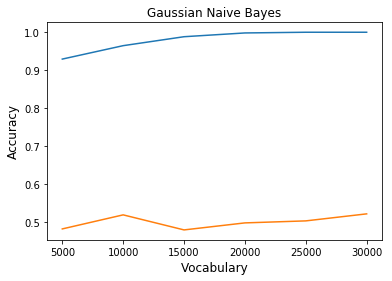

In [0]:
#Plotting Naive Bayes Accuracies
plt.plot(feature_size, training_score_nb)
plt.plot(feature_size, testing_score_nb)

plt.xlabel('Vocabulary', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Gaussian Naive Bayes")
plt.show()


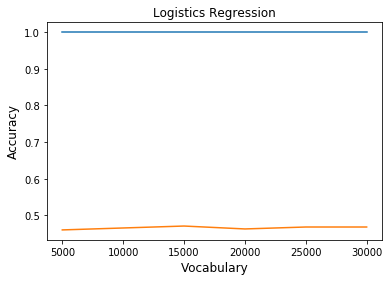

In [0]:
#Plotting Logistics Regression Accuracies
plt.plot(feature_size, training_score_log)
plt.plot(feature_size, testing_score_log)

plt.xlabel('Vocabulary', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Logistics Regression")
plt.show()